In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, big=True):
    if big:
        plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img, cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
def odd_num(num):
    if num % 2 == 0: return num + 1
    else: return num
    
flags = {
    'save_splits': False,
    'plot_mins': True
}

def show_contours(img, contour, size=(16,10), cnt_size=5, c_list=False):
    im = img.copy()
    if c_list:
        for i in contour: 
            for j in i:
                x,y = i.ravel()
                cv2.circle(im, (x,y), 5, [255,0,0], -1)
    else:
        for i in contour:
            x,y = i.ravel()
            cv2.circle(im, (x,y), 5, [255,0,0], -1)
    imshow(im)
    del im


In [2]:
img = cv2.imread('../preproc/images/im1.jpg',0)

ratio = 1500./img.shape[0]
img = cv2.resize(img, None, fx=ratio, fy=ratio)
im_height, im_width = img.shape

img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

In [4]:

# img = img[400:600,:]
# imshow(img)
# will crop these images to feed the NN

contours = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
print len(contours)
show_contours(img2, np.vstack(contours))

In [5]:
thresh = (255-img)/255
# imshow(thresh)

blurred = cv2.GaussianBlur(img/255, (1,55),0)
row_c = np.sum(blurred,axis = 0)

plt.figure(figsize=(17,3))
plt.plot(row_c)
plt.show()

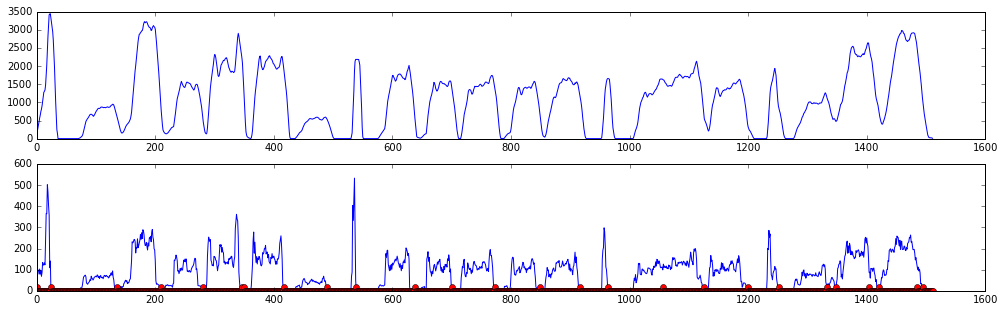

In [6]:
column = np.sum(thresh, axis = 1)
column -= column.min()

#long bills usually need to convolve less
conv_param = odd_num(int(30*img.shape[1]/float(2*img.shape[0])))
approx = np.convolve(column, np.ones(conv_param))

plt.figure(figsize=(17,5))
plt.subplot(211)
plt.plot(approx)
plt.subplot(212)
plt.plot(column)

candidates = np.argwhere(np.r_[False,approx[1:] < approx[:-1]] & np.r_[approx[1:] >= approx[:-1], False])
candidates = [x[0] for x in candidates[:-1]] + [im_height]

check = lambda x,th: (approx[max(0,x-th):min(x+th,im_height)] >= approx[x]).all() #y is the threshold
real_min = lambda x,th: np.argmin(column[max(x-th,0):min(x+th,im_height)])+max(x-th,0)


#problem with SUM here because need better check and real_min coefs
mins = [real_min(x,17) for x in candidates if check(x,15)]
mins = [0] + mins
#plot

if flags['plot_mins']:
    z = np.zeros_like(approx)
    w = np.zeros_like(approx)
    for c in mins:
        w[c] += 20
    plt.plot(w,'ro')
    plt.show()


In [77]:
split = [[max(0,mins[i-1]-3),mins[i]+3] for i in range(1,len(mins))]
print split

n_split = 5
edges = thresh[630:700,:]

[[0, 27], [21, 138], [132, 213], [207, 284], [278, 350], [344, 353], [347, 420], [414, 493], [487, 542], [536, 641], [635, 704], [698, 776], [770, 852], [846, 919], [913, 967], [961, 1059], [1053, 1128], [1122, 1202], [1196, 1255], [1249, 1336], [1330, 1351], [1345, 1407], [1401, 1423], [1417, 1488], [1482, 1498]]


In [90]:
# plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.imshow(img, cmap='Greys_r')

# for l in split:
#     plt.axhline(l[0],color='b')
#     plt.axhline(l[1],color='r')
# plt.show()


In [91]:
for s in split:
    column = np.sum(img[s[0]:s[1]], axis = 1)

In [92]:
m_t_y = [ x[0] for x in np.argwhere(column > 10)]

seqential = np.r_[np.subtract(m_t_y[:-1],m_t_y[1:]) != -1, True]
print seqential
l,j = (0,0)
for i in range(len(seqential)):
    if seqential[i] and len(m_t_y[j:i]) > l:
        main_text_y = (m_t_y[j:i])
        l = len(main_text_y)
        j = i
        
        

[False False False False False False False False False False False False
 False False False  True]


In [93]:
middle = int(np.mean(main_text_y))
width = len(main_text_y)
print middle, width
# print edges.shape

7 15


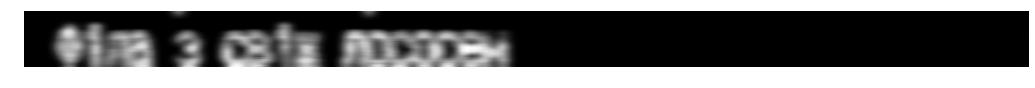

In [94]:
centered = edges #[max(0,middle-width/2):min(middle+width/2,img.shape[0]),:]*15

blurred = cv2.GaussianBlur(centered*255, (35,11),7)
imshow(blurred)

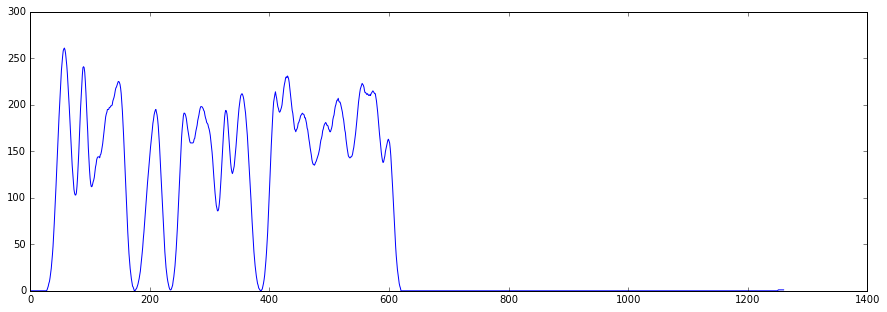

In [95]:
row = np.sum(blurred, axis=0)/15

plt.figure(figsize=(15,5))
plt.plot(row)

    

In [96]:
m_t_y = [ x[0] for x in np.argwhere(row > 2)]
# print m_t_y

seqential = np.r_[np.subtract(m_t_y[:-1],m_t_y[1:]) != -1, True]
pos = [m_t_y[x:x+2] for x in np.argwhere(seqential == True)[:,0]]

pos = [[np.argwhere(row > 2).min()]]+pos
print pos
words = [centered[:,max(0,pos[i-1][-1]-5):pos[i][0]+5] for i in range(1,len(pos))]

[[29], [172, 178], [232, 237], [382, 389], [619]]


In [97]:
print len(words)

4


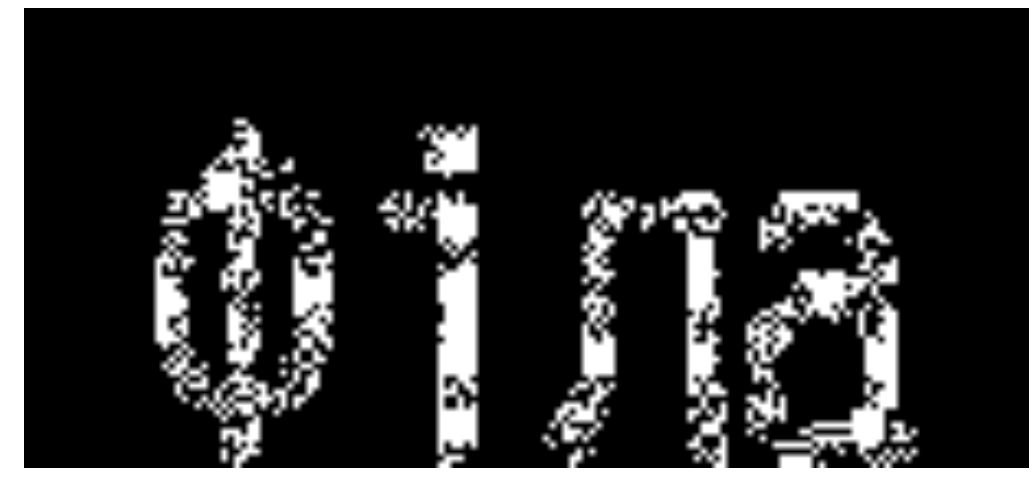

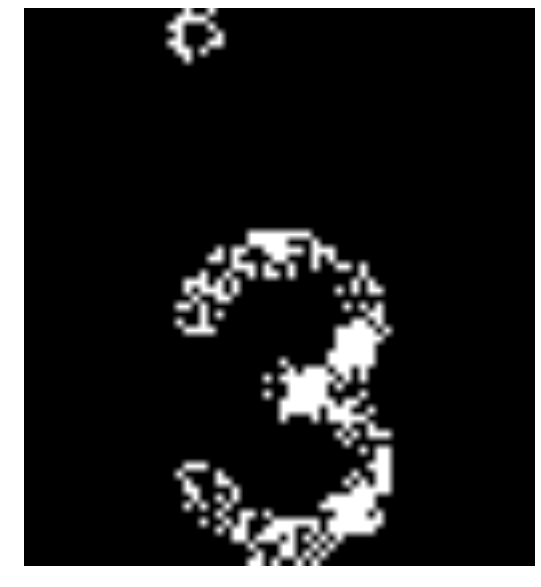

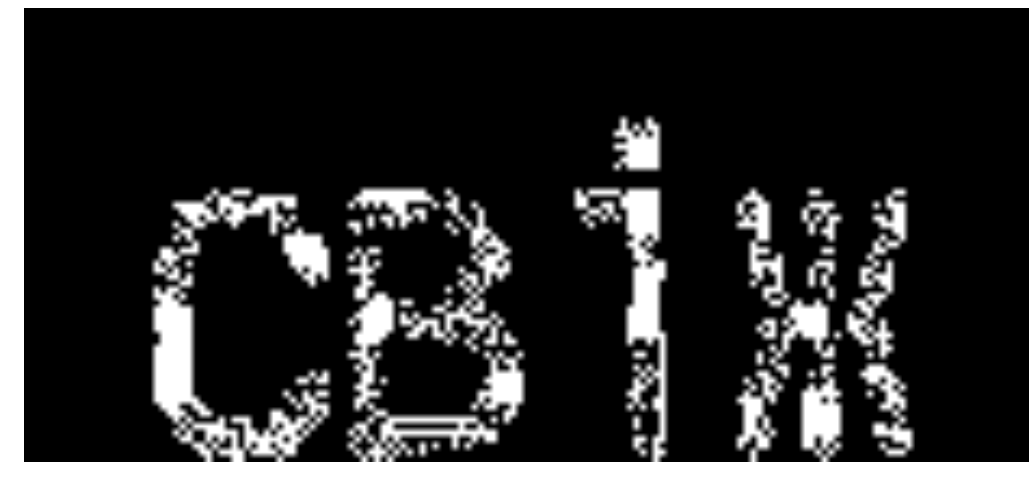

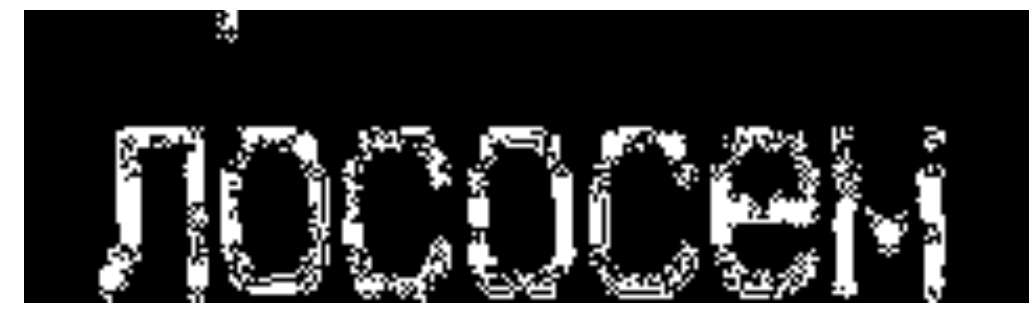

In [98]:
for i in words:
    imshow(i)

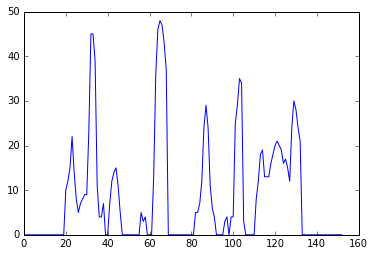

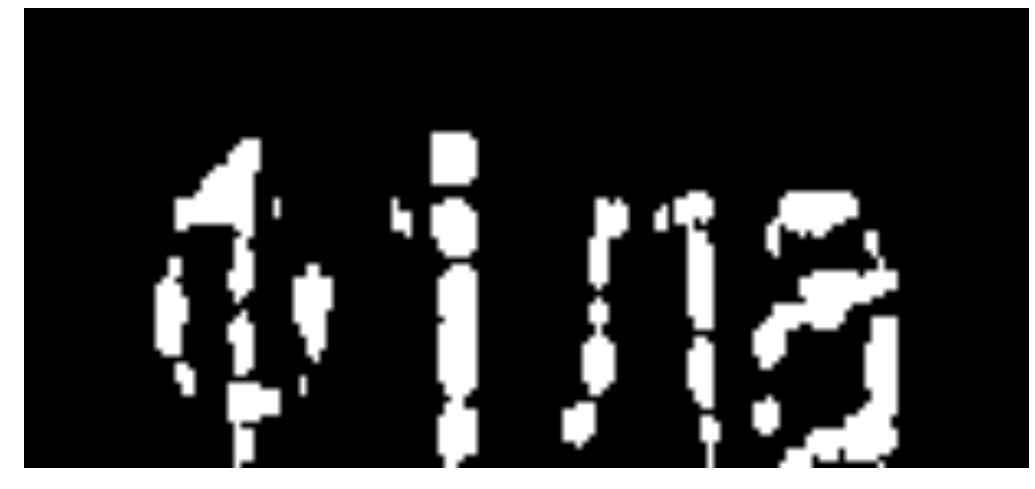

In [99]:
word = words[0]
word = cv2.GaussianBlur(word,(5,3),5)
word = cv2.dilate(word,(25,17),iterations=2)
row2 = np.sum(word,axis=0)
plt.plot(row2)
imshow(word)

In [100]:
lettrs = [ x[0] for x in np.argwhere(row2 > 20)]
seqential = np.r_[np.subtract(lettrs[:-1],lettrs[1:]) != -1, True]
pos = [lettrs[x:x+2] for x in np.argwhere(seqential == True)[:,0]]

pos = [[np.argwhere(row2 > 20).min()]] + pos
print 
letters = [word[:,max(0,pos[i-1][-1]-2):pos[i][0]+2] for i in range(1,len(pos))]
print len(letters)


7


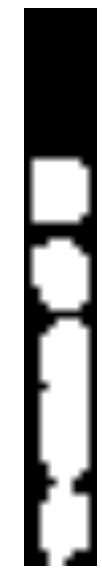

In [101]:
imshow(letters[2])